In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchmetrics.functional.classification import binary_auroc, binary_accuracy
import numpy as np
from tqdm.notebook import tnrange, tqdm
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
## https://www.cs.toronto.edu/~kriz/cifar.html

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [2]:

cifar10 = torch.empty(5, 10000, 3, 32, 32)
cifar_y = torch.empty(5, 10000)
for i in range(5):
    batch = unpickle("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\cifar10-data\\cifar-10-batches-py\\data_batch_"+str(i+1))
    image_data = batch[b'data'].reshape(10000,3,32,32)
    cifar10[i] = torch.from_numpy(image_data)
    cifar_y[i] = torch.tensor(batch[b'labels'])
    
meta_file = 'C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\cifar10-data\\cifar-10-batches-py\\batches.meta'
meta_data = unpickle(meta_file)

In [3]:
meta_data

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [4]:
def make_datasets(x, y, batch_size = 100, train_test_percent = 0.2):
    """
    Batch size must be multiple of 4
    """
    
    reshape_x = x.reshape((-1, 
                              x.size()[2],
                              x.size()[3],
                              x.size()[4]))#.squeeze(0)
    batch_x = reshape_x.view((-1, batch_size,reshape_x.size()[1],
                              reshape_x.size()[2],
                              reshape_x.size()[3]))

    train_x = batch_x[:-int(batch_x.size()[0]*train_test_percent)]
    test_x = batch_x[-int(batch_x.size()[0]*train_test_percent):]
    
    reshape_y = y.reshape((np.prod(list(y.size()))))
    batch_y = reshape_y.view((-1, batch_size))
    
    train_y = batch_y[:-int(batch_y.size()[0]*train_test_percent)]
    test_y = batch_y[-int(batch_y.size()[0]*train_test_percent):]
    
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = make_datasets(cifar10, cifar_y, batch_size = 100, train_test_percent = .2)

In [5]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


Text(0.5, 1.0, "b'frog'")

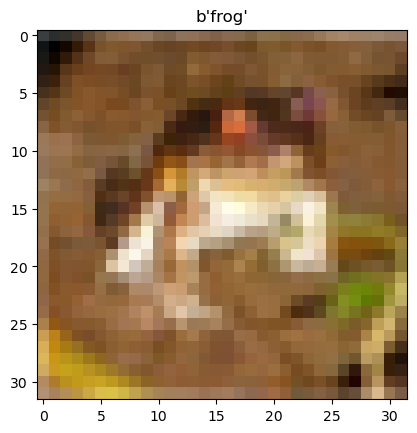

In [7]:
cifar10[0,0]
plt.imshow(cifar10[0,0].permute(1,2,0)/255)
plt.title(meta_data[b'label_names'][int(cifar_y[0,0])])

In [8]:
class Generator(nn.Module):
    def __init__(self, batch_size, z_dim, channel_dim, feature_dim):
        """
        Convolutional Generator
        """
        super(Generator, self).__init__()
        # Parameters
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.feature_dim = feature_dim
        
        # Modules
        self.layer_0 = nn.Sequential(nn.ConvTranspose2d(z_dim, 1024, kernel_size = 4, 
                                                        stride =1, padding = 0, bias = False),
                                     nn.BatchNorm2d(1024),
                                     nn.ReLU())
        
        self.layer_1 = nn.Sequential(nn.ConvTranspose2d(in_channels = 1024, 
                                          out_channels = 512,
                                          kernel_size = 4, stride=2, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.layer_2 = nn.Sequential(nn.ConvTranspose2d(in_channels = 512, 
                                          out_channels = 256,
                                          kernel_size = 4, stride=2, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.layer_3 = nn.Sequential(nn.ConvTranspose2d(in_channels = 256, 
                                          out_channels = 128,
                                          kernel_size = 4, stride=2, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.layer_4 = nn.Sequential(nn.ConvTranspose2d(in_channels = 128, 
                                          out_channels = 64,
                                          kernel_size = 4, stride=1, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.layer_5 = nn.Sequential(nn.ConvTranspose2d(in_channels = 64, 
                                          out_channels = 3,
                                          kernel_size = 2, stride=1, 
                                          padding=1, bias=False))
        
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        l0 = self.layer_0(input)
        
        # l0 = l0.view(self.batch_size, -1, 5, 5)
        l1 = self.layer_1(l0)
        l2 = self.layer_2(l1)
        l3 = self.layer_3(l2)
        l4 = self.layer_4(l3)
        l5 = self.layer_5(l4)
        out = self.tanh(l5)
        return out

In [9]:
z_dim = 100
z = torch.randn(batch_size, z_dim, 1, 1)

NameError: name 'batch_size' is not defined

In [10]:
G = Generator(batch_size = batch_size, z_dim = z_dim, channel_dim = 3, feature_dim = 32 * (2**3))
faked = G.forward(z)
faked.size()

NameError: name 'batch_size' is not defined

In [11]:
# faked[4].permute(1,2,0).detach().numpy()

In [12]:
plt.imshow(faked[4].permute(1,2,0).detach().numpy())
plt.title("Generated Data")
plt.show()

NameError: name 'faked' is not defined

In [13]:
class Discriminator(nn.Module):
    def __init__(self, channels, dim):
        super(Discriminator,self).__init__()
        #parameters
        
        #modules
        self.layer_0 = nn.Sequential(nn.Conv2d(channels, 
                                               dim, 
                                               kernel_size = 2, 
                                               stride= 1, 
                                               padding = 1, bias = False),
                                     nn.LeakyReLU(.2))  #(b, 3, 32, 32)
        
        self.layer_1 = nn.Sequential(nn.Conv2d(dim, dim*2, kernel_size = 4, stride= 1, padding = 1, bias = False),
                                     nn.BatchNorm2d(dim*2),
                                     nn.LeakyReLU(0.2))#64
        
        self.layer_2 = nn.Sequential(nn.Conv2d(dim*2, dim*2**2, kernel_size = 4, stride= 2, padding = 1, bias = False),
                                     nn.BatchNorm2d(dim*2**2),
                                     nn.LeakyReLU(0.2))#128
        self.layer_3 = nn.Sequential(nn.Conv2d(dim*2**2, dim*2**3, kernel_size = 4, stride= 2, padding = 1, bias = False),
                                     nn.BatchNorm2d(dim*2**3),
                                     nn.LeakyReLU(0.2))#256
        self.layer_4 = nn.Sequential(nn.Conv2d(dim*2**3, dim*2**4, kernel_size = 4, stride= 2, padding = 1, bias = False),
                                     nn.BatchNorm2d(dim*2**4),
                                     nn.LeakyReLU(0.2))#512
        self.layer_5 = nn.Sequential(nn.Conv2d(dim*2**4, dim*2**5, kernel_size = 4, stride= 2, padding = 1, bias = False),
                                     nn.BatchNorm2d(dim*2**5),
                                     nn.LeakyReLU(0.2))#1024
        
        self.fully_connected = nn.Sequential(nn.Conv2d(dim*2**5, 1, kernel_size = 4, stride= 1, padding = 1, bias = False),
                                            nn.Sigmoid())
    def forward(self, input):
        l0 = self.layer_0(input)
        l1 = self.layer_1(l0)
        l2 = self.layer_2(l1)
        l3 = self.layer_3(l2)
        l4 = self.layer_4(l3)
        l5 = self.layer_5(l4)
        
        out = self.fully_connected(l5)
        return out[:,0,0,0]
        
        

In [14]:
D = Discriminator(channels = 3, dim = 32)

output = D(faked)
output.size()

NameError: name 'faked' is not defined

In [15]:
lr = 0.0002

MSE = nn.MSELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

NameError: name 'G' is not defined

In [16]:
from fastprogress import master_bar, progress_bar

In [35]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

label = 1
dataset.targets = (torch.Tensor(dataset.targets) == 1).type(torch.float)
test_dataset.targets = (torch.Tensor(test_dataset.targets) == 1).type(torch.float)

dataset = torch.utils.data.Subset(dataset, (dataset.targets == label).nonzero(as_tuple=True)[0])

batch_size = 250
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2)

Files already downloaded and verified


In [18]:
def plot_loss_update(epoch, j, epochs, mb, G_Loss, D_Loss, D_real, D_fake):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = np.arange(0, (len(G_Loss)/20), 1/20)
    if x.size == 0:
        x = 0
    y = np.array([G_Loss, D_Loss, D_real, D_fake])
    graphs = [[x,G_Loss], [x,D_Loss], [x,D_fake], [x,D_real]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [0, epoch+(j/20)+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

In [19]:
np.arange(0, (2/20), 1/20)


array([0.  , 0.05])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


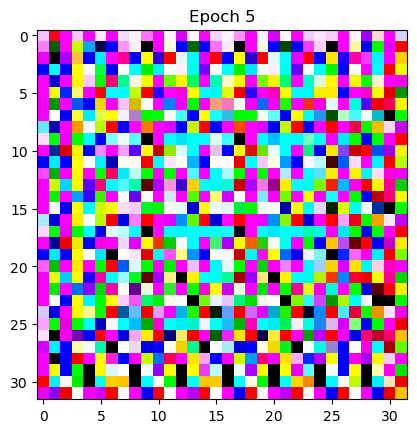

In [41]:
z_dim = 100
# batch_size = 400


train_loader = train_loader
test_loader =test_loader


G = Generator(batch_size = batch_size, z_dim = z_dim, channel_dim = 3, feature_dim = 32 * (2**3))
D = Discriminator(channels = 3, dim = 32)

MSE = nn.BCELoss()
lr =  0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5,0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5,0.999))

# target = One_Class_CIFAR(train_y, label = 1)
epochs = 10

AUROC_converg = []

g_list = []
d_list = []
fake_list = []
real_list = []

mb = master_bar(range(epochs))
mb.names = ['G Loss', 'D Loss', "D Fake", "D Real"]
plt.ion()
fig = plt.figure()
ax  = plt.subplot(111)
im = None
for epoch in mb:
    # Training Loo[
    for j,(image,y) in enumerate(progress_bar(train_loader, parent = mb)):
        image = Variable(image)

        
        
        #Discriminator
        ones = Variable(torch.ones(batch_size))
        zeros = Variable(torch.zeros(batch_size))
        D_optimizer.zero_grad()
        z = Variable(torch.randn(batch_size, z_dim, 1, 1))
        G_image = G.forward(z)
        D_fake = D.forward(G_image)
        D_fake_loss = MSE(D_fake, zeros) #-torch.mean(torch.log(1 - D_fake + 1e-8))#
        D_real = D.forward(image[y == 1])
        D_real_loss = MSE(D_real, y[y==1]) #-torch.mean(torch.log(D_real + 1e-8))#

        D_loss = D_fake_loss + D_real_loss #-torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))   #
        D_real_loss.backward()
        D_fake_loss.backward()
        
        D_optimizer.step()
        
        #Generator
        G_optimizer.zero_grad()
        batch_size = int(image.size()[0])
        z = Variable(torch.randn(batch_size, z_dim, 1, 1))
        G_Fake = D.forward(G.forward(z))
        G_loss = MSE(G_Fake, ones) #-torch.mean(torch.log(G_Fake + 1e-8))
        G_loss.backward(retain_graph=True)
        G_optimizer.step()
        
        g_list.append(float(G_loss.data))
        d_list.append(float(D_loss.data))
        fake_list.append(float(D_fake_loss.data))
        real_list.append(float(D_real_loss.data))
        
        AUROC = binary_auroc(D_real, y[y ==1])
        ACC = binary_accuracy(D_real, y[y ==1])

        # plot_loss_update(epoch,j, epochs, mb, g_list, d_list, fake_list, real_list)
        mb.child.comment = "{} epoch {}th iteration gen_loss: {} dis_loss: {} AUROC: {} ACC: {}".format(epoch, j,G_loss.data,D_loss.data, AUROC.data, ACC.data)
        if (epoch % 5 == 0) & (j == 0):
            plt.imshow(G_image[0].detach().permute(1,2,0))
            plt.title("Epoch {}".format(epoch))
            plt.savefig("Trial{}.png".format(epoch))
    
    
    # Test Loop
    batch_acc = []
    batch_auroc = []
    for j,(image,y) in enumerate(progress_bar(test_loader, parent = mb)):
        image = Variable(image)

        
        
        #Discriminator
        ones = Variable(torch.ones(batch_size))
        zeros = Variable(torch.zeros(batch_size))
        D_optimizer.zero_grad()
        z = Variable(torch.randn(batch_size, z_dim, 1, 1))
        G_image = G.forward(z)
        D_fake = D.forward(G_image)
        D_fake_loss = MSE(D_fake, zeros) #-torch.mean(torch.log(1 - D_fake + 1e-8))#
        D_real = D.forward(image)
        D_real_loss = MSE(D_real, y) #-torch.mean(torch.log(D_real + 1e-8))#

        D_loss = D_fake_loss + D_real_loss #-torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))   #
        # D_real_loss.backward()
        # D_fake_loss.backward()
        
        # D_optimizer.step()
        
        #Generator
        G_optimizer.zero_grad()
        batch_size = int(image.size()[0])
        z = Variable(torch.randn(batch_size, z_dim, 1, 1))
        G_Fake = D.forward(G.forward(z))
        G_loss = -torch.mean(torch.log(G_Fake + 1e-8)) #MSE(G_Fake, ones)
        # G_loss.backward(retain_graph=True)
        # G_optimizer.step()
        
        g_list.append(float(G_loss.data))
        d_list.append(float(D_loss.data))
        fake_list.append(float(D_fake_loss.data))
        real_list.append(float(D_real_loss.data))
        
        AUROC = binary_auroc(D_real, y)
        ACC = binary_accuracy(D_real[y == 1], y[y==1])
        batch_auroc.append(float(AUROC.data))
        batch_acc.append(float(ACC.data))
        # plot_loss_update(epoch,j, epochs, mb, g_list, d_list, fake_list, real_list)
        mb.child.comment = "{} epoch {}th iteration gen_loss: {} dis_loss: {} AUROC: {} ACC: {}".format(epoch, j,G_loss.data,D_loss.data, AUROC.data, ACC.data)
    
    AUROC_converg.append(sum (batch_auroc) / len (batch_auroc))
    mb.main_bar.comment = "{} epoch {} AUROC {} ACC".format(epoch, sum (batch_auroc) / len (batch_auroc), sum (batch_acc) / len (batch_acc))
        # if j % 3 == 0:
        #     print("{} epoch {}th iteration gen_loss: {} dis_loss: {} D fake: {} D real: {}".format(epoch, j,G_loss.data,D_loss.data, D_fake_loss.data, D_real_loss.data))
        #     plt.imshow(G_image[0].detach().permute(1,2,0))
        #     plt.show()
            # im.draw()
            # fig.canvas.flush_events()
        # mb.child.comment = str(binary_auroc(D_real.squeeze(1), y).item())
        # batch_AUROC[batch] = binary_auroc(D_real.squeeze(1), y)
        
    # AUROC_converg.append(batch_AUROC.mean())
    # mb.main_bar.comment = str(AUROC_converg[-1])
    
    # if epoch % 25 == 0:
    #     mb.write("gen_loss: {} dis_loss: {}".format(epoch,G_loss.data,D_loss.data))
    #     mb.write("AUROC: {}".format(AUROC_converg[-1]))
            

In [44]:
AUROC_converg

[0.46307881847023963,
 0.45051551014184954,
 0.44867066740989686,
 0.44160283729434013,
 0.43246695324778556,
 0.4312446370720863,
 0.44054808393120765,
 0.64618571549654,
 0.64022426456213,
 0.6935473829507828]

In [46]:
binary_accuracy(D_real, y)

tensor(0.1080)

In [48]:
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 